<a href="https://colab.research.google.com/github/dchowdhury-mdsol/CMP-765/blob/main/6/class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 6
# More Examples on Pretrained Neural Networks

- Create a generative adversarial network (GAN) with pretrained parameters.
- Use a image caption model published on Github
- Use pretrained models on PyTorch Hub.

Readings: Chapter 2 - Pretrained Networks

## CycleGAN

A CycleGAN is a deep learning system that can turn a photo of a horse into a zebra, and vice versa.

**Generative Adversarial Networks**
A **generative adversarial network (GAN)** is a class of machine learning frameworks and a important framework for approaching generative AI.
- The concept was initially developed by Ian Goodfellow and his colleagues in June 2014.
- In a GAN, there are two neural networks: a generator network and a discriminator network.
- The generator network aims to generate a product (image, audio, ect.) based on user inputs.
- The discriminator network aims to distinguish between a real item and a fake item (generated by the generator network).
- During the training process, the generator network is designed to generate products that are difficult to discriminate from the real ones; the discriminator network is designed to be better at identifying fake items. In the end, both networks are expected to be very good at their jobs.

<img src="https://theaisummer.com/static/96b97962043562751964d44de324b984/39240/gan.jpg" height="500">

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [ ]:
class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3>

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

In [ ]:
netG = ResNetGenerator()

In [ ]:
!wget https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse2zebra_0.4.0.pth

--2025-02-26 15:22:35--  https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse2zebra_0.4.0.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse2zebra_0.4.0.pth [following]
--2025-02-26 15:22:35--  https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse2zebra_0.4.0.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45519250 (43M) [application/octet-stream]
Saving to: ‘horse2zebra_0.4.0.pth’

horse2zebra_0.4.0.p 100%[===================>]  43.41M  --.-KB/s    in 0.1s

In [ ]:
model_path = '/content/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)
netG.eval()

<ipython-input-6-10611e23cbbb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(model_path)


ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [ ]:
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([transforms.Resize([256, 256]),
                                 transforms.ToTensor()])

In [ ]:
! wget "https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse.jpg?raw=true" -O horse.jpg
! wget "https://www.tastingtable.com/img/gallery/ive-tried-horse-meat-here-are-my-thoughts/l-intro-1682539768.jpg" -O "horse2.jpg"
! wget "https://cdn.britannica.com/92/1292-050-92C981ED/Appaloosa-mare-bay-colouring.jpg" -O "horse3.jpg"

--2025-02-26 15:30:22--  https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/refs/heads/master/data/p1ch2/horse.jpg [following]
--2025-02-26 15:30:23--  https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/refs/heads/master/data/p1ch2/horse.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/refs/heads/master/data/p1ch2/horse.jpg [following]
--2025-02-26 15:30:23--  https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/refs/heads/master/data/p1ch2/horse.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.1

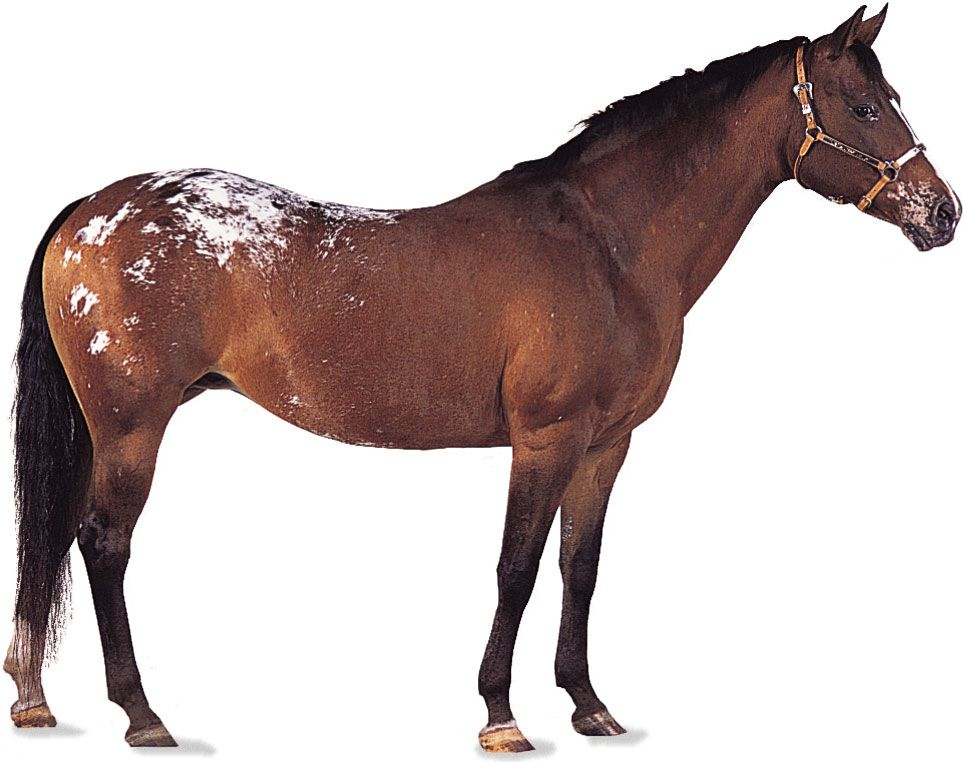

In [ ]:
img = Image.open("/content/horse3.jpg")
img

In [ ]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
batch_t.shape

torch.Size([1, 3, 256, 256])

In [ ]:
batch_out = netG(batch_t)

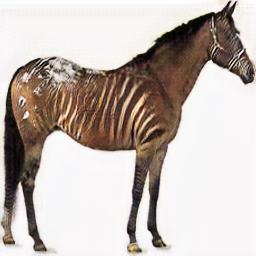

In [ ]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img.save('zebra.jpg')
out_img

In [ ]:
# Exercise: Find another image with a horse, and convert it to a zebra using CycleGAN.
! wget "https://b1195915.smushcdn.com/1195915/wp-content/uploads/2021/05/woodrow-rearing-square.jpg?lossy=2&strip=1&webp=1" -O "anotherhorse.jpg"

--2025-02-26 15:42:36--  https://b1195915.smushcdn.com/1195915/wp-content/uploads/2021/05/woodrow-rearing-square.jpg?lossy=2&strip=1&webp=1
Resolving b1195915.smushcdn.com (b1195915.smushcdn.com)... 84.17.46.54, 2400:52e0:1e01::1056:1
Connecting to b1195915.smushcdn.com (b1195915.smushcdn.com)|84.17.46.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123962 (121K) [image/jpeg]
Saving to: ‘anotherhorse.jpg’

anotherhorse.jpg    100%[===================>] 121.06K  --.-KB/s    in 0.03s   

2025-02-26 15:42:36 (4.43 MB/s) - ‘anotherhorse.jpg’ saved [123962/123962]

anotherhorse.jpg  horse2.jpg  horse2zebra_0.4.0.pth  horse3.jpg  horse.jpg  sample_data  zebra.jpg


In [ ]:
# Other useful console commands
! ls
! mkdir temp

anotherhorse.jpg  horse2.jpg  horse2zebra_0.4.0.pth  horse3.jpg  horse.jpg  sample_data  zebra.jpg


In [ ]:
img = Image.open("/content/anotherhorse.jpg")

In [ ]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
batch_out = netG(batch_t)

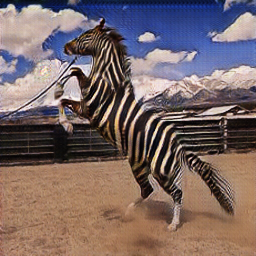

In [ ]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img

## NeuralTalk2

In this section, let's explore a pretrained image-captioning system, which is an implementation of the NeuralTalk 2 model developed by [Andrej Karpathy](https://karpathy.ai/) in 2016.
- The vision component uses the Inception V3 model, which achieves 93.9% accuracy on the ImageNet classification task.
- The language component is a **recurrent neural network**, which generates a sentence by generating each word sequencially.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*phpgEszN4Q6n_Rtd24zpGw.png" height="400">


In [ ]:
! git clone https://github.com/deep-learning-with-pytorch/ImageCaptioning.pytorch.git

Cloning into 'ImageCaptioning.pytorch'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 519 (delta 0), reused 0 (delta 0), pack-reused 518 (from 1)
Receiving objects: 100% (519/519), 206.53 MiB | 38.71 MiB/s, done.
Resolving deltas: 100% (328/328), done.
Updating files: 100% (28/28), done.


In [ ]:
# Change the default directory to this project folder
%cd ImageCaptioning.pytorch/

/content/ImageCaptioning.pytorch


In [ ]:
# Move the horse.jpg file to the data folder
! mv ../horse.jpg ./data
! mv ../horse2.jpg ./data
! mv ../horse3.jpg ./data
! mv ../anotherhorse.jpg ./data
! ls ./data

mv: cannot stat '../horse.jpg': No such file or directory
mv: cannot stat '../horse2.jpg': No such file or directory
mv: cannot stat '../horse3.jpg': No such file or directory
anotherhorse.jpg  FC  horse2.jpg  horse3.jpg  horse.jpg  imagenet_weights


In [ ]:
# Follow the instructions from the Github page to evaluate the image
! python eval.py --model ./data/FC/fc-model.pth --infos_path ./data/FC/fc-infos.pkl --image_folder ./data --num_images 4

/content/ImageCaptioning.pytorch/eval.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(opt.model, map_location=torch.device(device)))
/

In [ ]:
# Exercise: Find another image online and generate caption on it.
! wget https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AA1qX8fL.img?w=728&h=400&m=6&x=598&y=115&s=63&d=63 -O ./data/image.jpg
! ls ./data

## PyTorch Hub
[Pytorch Hub](https://pytorch.org/hub/research-models) is a pre-trained model repository designed to facilitate research reproducibility. It supports publishing pre-trained models to a Github repository by adding a `hubconf.py` file.

Here is a demostration on loading DCGAN from PyTorch Hub and use it to generate fashion images. DCGAN was published in 2016, and it is one of the first generation of GAN models that uses **convolutional layers** for better understanding image data. This demonstration is inspired by [this online article](https://pyimagesearch.com/2021/12/20/torch-hub-series-1-introduction-to-torch-hub/#pyis-cta-modal) by Devjyoti Chakraborty.

In [ ]:
import matplotlib.pyplot as plt # a plotting library
import torchvision
import torch

In [ ]:
useGpu = True if torch.cuda.is_available() else False
print(useGpu)

True


In [ ]:
model = torch.hub.load("facebookresearch/pytorch_GAN_zoo:hub", "DCGAN",
	pretrained=True, useGPU=useGpu)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to /root/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/DCGAN_fashionGen-1d67302.pth" to /root/.cache/torch/hub/checkpoints/DCGAN_fashionGen-1d67302.pth
100%|██████████| 39.7M/39.7M [00:00<00:00, 150MB/s]


Average network found !


In [ ]:
# generate random noise to input to the generator
num_images = 64
(noise, _) = model.buildNoiseData(num_images)

In [ ]:
# The input instances are random noises of size 120
noise.shape

torch.Size([64, 120])

In [ ]:
# turn off autograd and feed the input noise to the model
with torch.no_grad():
	generatedImages = model.test(noise)

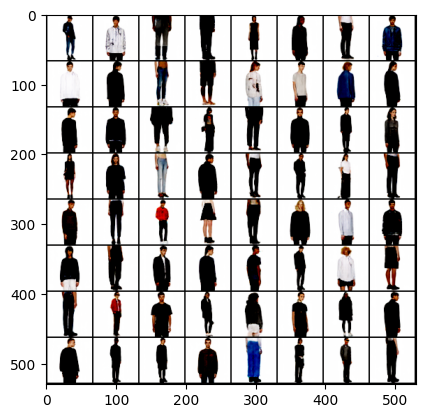

In [ ]:
output = torchvision.utils.make_grid(generatedImages).permute(
	1, 2, 0).cpu().numpy()
plt.imshow(output)
plt.show()

Here is another example with [StyleGAN](https://en.wikipedia.org/wiki/StyleGAN): (If you see an error below, please restart the session and start from here)

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch

In [ ]:
model = torch.hub.load('ndahlquist/pytorch-hub-stylegan:0.0.1', 'style_gan', pretrained=True)

Using cache found in /root/.cache/torch/hub/ndahlquist_pytorch-hub-stylegan_0.0.1
Downloading: "https://github.com/ndahlquist/lernapparat/releases/download/0.0.0/karras2019stylegan-ffhq-1024x1024.for_g_all-b418e00b3f4f99b879c3e805b8c55e.pt" to /root/.cache/torch/hub/checkpoints/karras2019stylegan-ffhq-1024x1024.for_g_all-b418e00b3f4f99b879c3e805b8c55e.pt
100%|██████████| 100M/100M [00:03<00:00, 29.9MB/s] 


In [ ]:
model.eval()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

Sequential(
  (g_mapping): G_mapping(
    (pixel_norm): PixelNormLayer()
    (dense0): MyLinear()
    (dense0_act): LeakyReLU(negative_slope=0.2)
    (dense1): MyLinear()
    (dense1_act): LeakyReLU(negative_slope=0.2)
    (dense2): MyLinear()
    (dense2_act): LeakyReLU(negative_slope=0.2)
    (dense3): MyLinear()
    (dense3_act): LeakyReLU(negative_slope=0.2)
    (dense4): MyLinear()
    (dense4_act): LeakyReLU(negative_slope=0.2)
    (dense5): MyLinear()
    (dense5_act): LeakyReLU(negative_slope=0.2)
    (dense6): MyLinear()
    (dense6_act): LeakyReLU(negative_slope=0.2)
    (dense7): MyLinear()
    (dense7_act): LeakyReLU(negative_slope=0.2)
  )
  (g_synthesis): G_synthesis(
    (torgb): MyConv2d()
    (blocks): ModuleDict(
      (4x4): InputBlock(
        (epi1): LayerEpilogue(
          (top_epi): Sequential(
            (noise): NoiseLayer()
            (activation): LeakyReLU(negative_slope=0.2)
            (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine

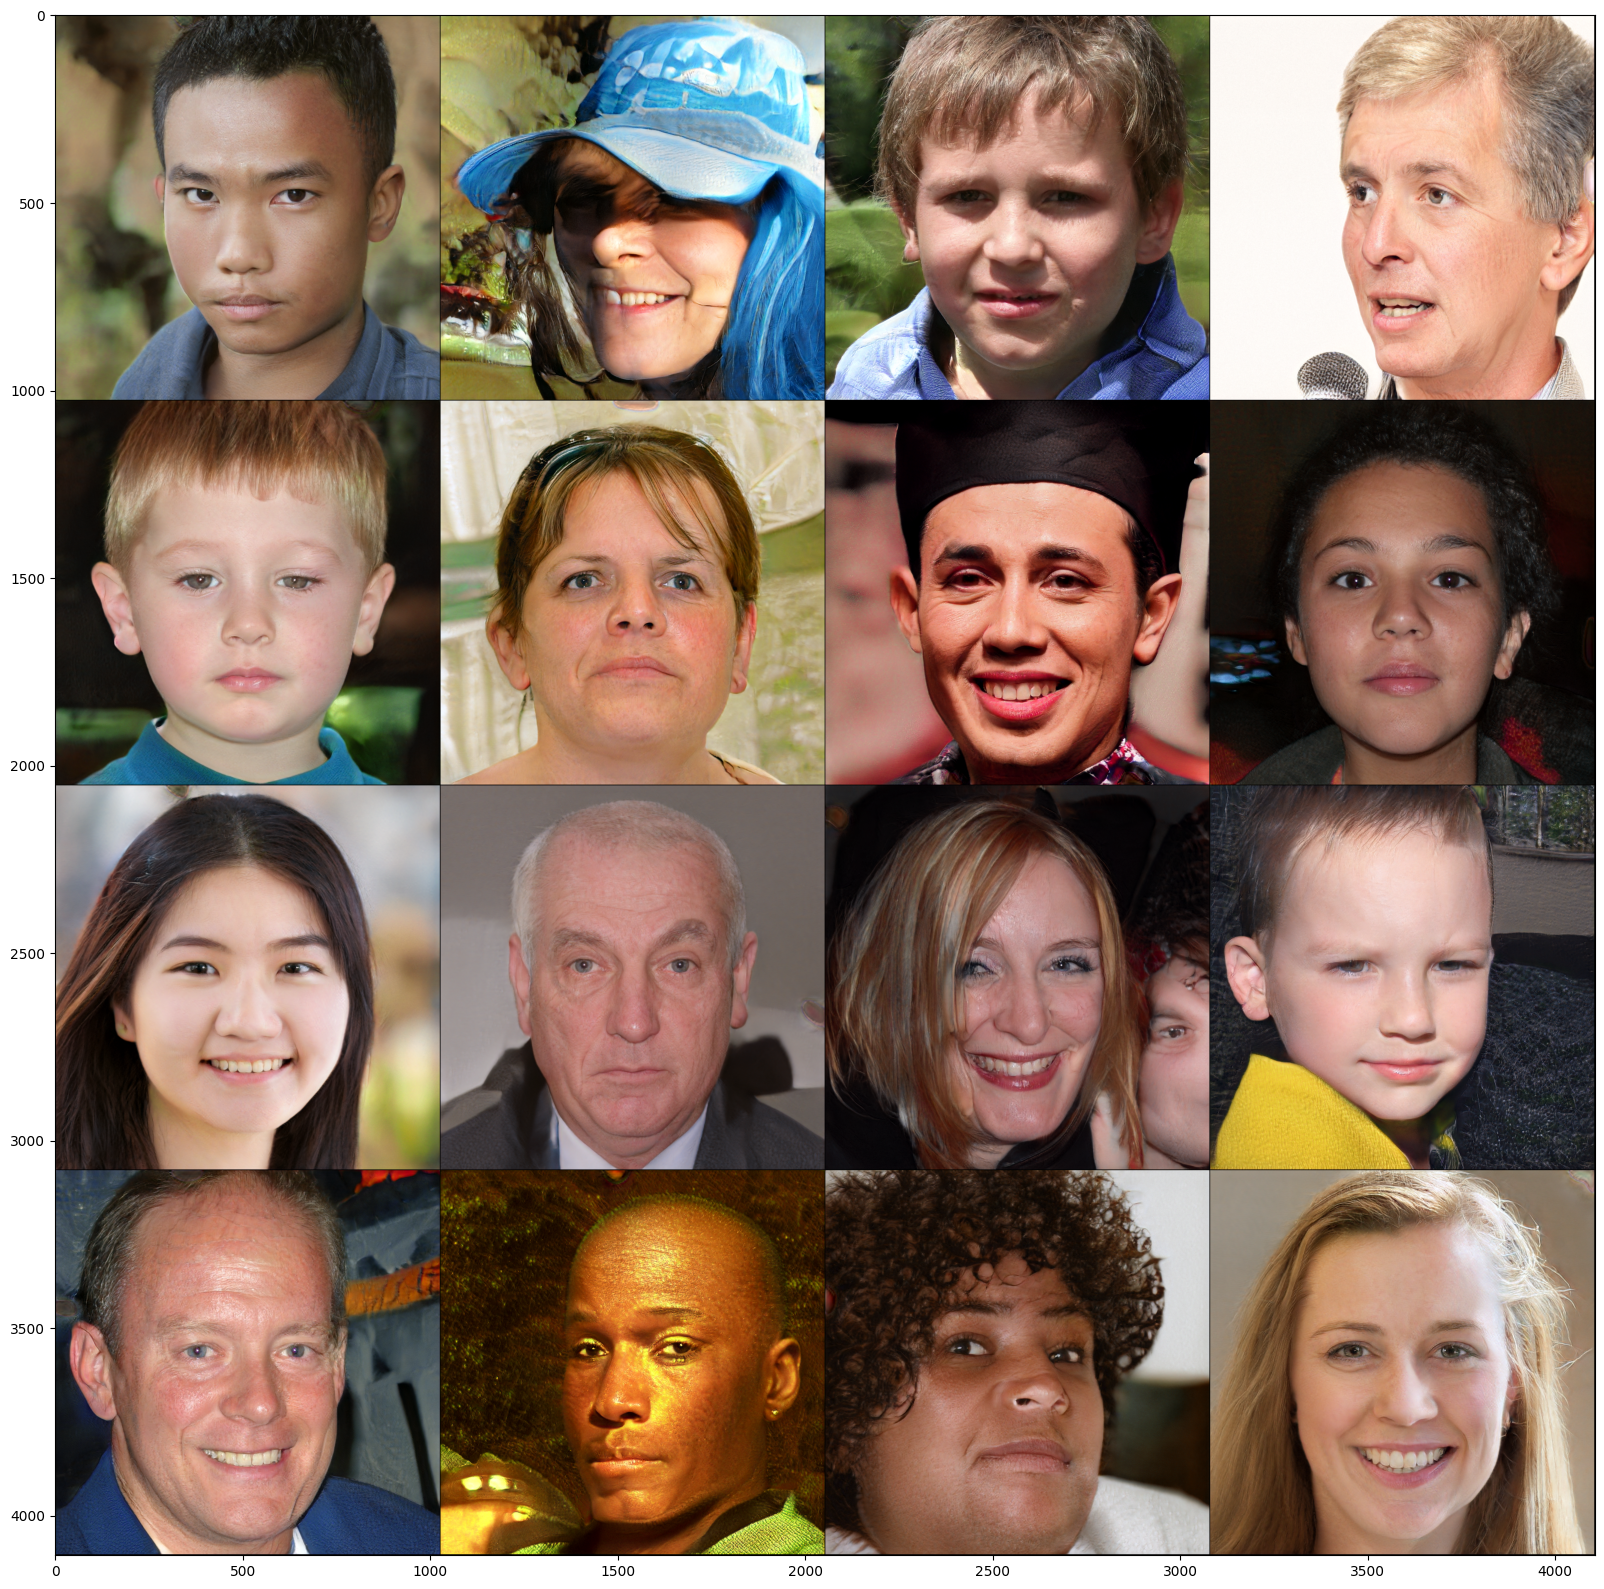

In [ ]:
import matplotlib.pyplot as plt
nb_rows = 4
nb_cols = 4
nb_samples = nb_rows * nb_cols
latents = torch.randn(nb_samples, 512, device=device)
with torch.no_grad():
    imgs = model(latents)
    # normalization to 0..1 range
    imgs = (imgs.clamp(-1, 1) + 1) / 2.0
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

plt.figure(figsize=(20, 20))
plt.imshow(imgs.permute(1, 2, 0).detach().numpy())

plt.show()

### Exercise: Load AlexNet from PyTorch Hub
Read the [AlexNet page](https://pytorch.org/hub/pytorch_vision_alexnet/) on PyTorch Hub, and use it to identify the label of an image.